**File 2017-05-11 also gives left turn**

**Visualize all tracks in file '2017-05-17_00h_tracks.csv' :**

In [29]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import os
import csv

num_TOs = 1500

# Loading original tracks data:
cols = ['ID','Time','x', 'y','Speed','Type','Estimated']
data = pd.read_csv('2017-05-17_00h_tracks.csv',index_col=False, header=None,sep=';',names=cols )
data = data.drop(data.index[0])   # drops the first row
df = data[(data['Type'] == 2)]  # only selecting TO of type 2 (car)


# creating new data frame for plotting trajectories: 
df = df[['ID', 'Time','x', 'y']]

print(df.head())

# path to to put saved file:
path = r'C:\Users\Desktop\CAS\Project_course_math_stat_modelling\2017_05_17_L'

# the file is currently named 'selected_path.csv':
df.to_csv(os.path.join(path, r'xy_all.csv'), index=False)

print('Selected paths saved to csv !')

C:\Users\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (0,2,3,4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


               ID                              Time        x        y
131072  200019253  2017-05-17 07:47:05.246000+02:00  26.2837  11.5698
131073  200019253  2017-05-17 07:47:05.498000+02:00  26.3034  11.5635
131074  200019253  2017-05-17 07:47:05.751000+02:00  26.3205  11.5549
131075  200019253  2017-05-17 07:47:06.004000+02:00  26.3366  11.5538
131076  200019253  2017-05-17 07:47:06.257000+02:00  26.3449  11.5518
Selected paths saved to csv !


**Conversion to lat-long coord:**

In [49]:
import pandas as pd
import numpy as np
from pandas import DataFrame
import os
import csv

""" Converts data x-y coordinates into latitudinal and longitudinal positions.
 Specify below the path where the csv file is to be saved. Requires Pandas and Numpy package."""

########################################################################################################################
# lat <=> y, long <=> x
ref_position = np.array([59.916559, 10.734520])
lat = 59.916687
lon = 10.734836
position = [lat, lon]

diff_lat = position[0] - ref_position[0]
diff_lon = position[1] - ref_position[1]

diff_x = 23.41
diff_y = -20

const_lat = np.round(diff_lat/diff_y, 6)
const_lon = np.round(diff_lon/diff_x, 6)

theta = np.pi + np.pi/2

########################################################################################################################

cols = ['ID','Time','x', 'y']

# Add the csv file to be converted here:
df = pd.read_csv(r'C:\Users\Desktop\CAS\Project_course_math_stat_modelling\2017_05_17_L\xy_L_2017_05_17_filtered.csv', index_col=False, header=None, sep=',', names= cols)
df = df.drop(df.index[0])   # drops the first row

df['lat'] = df['y'].astype(float)
df['long'] = df['x'].astype(float)
df['x'] = df['long'].astype(float)
df['y'] = df['lat'].astype(float)

# rotate x-y-coordinates by pi/2:
#df['x_new'] = df['x'].multiply(np.cos(theta)) - df['y'].multiply(np.sin(theta))
#df['y_new'] = df['x'].multiply(np.sin(theta)) + df['y'].multiply(np.cos(theta))

df['const_lat'] = const_lat
df['const_long'] = const_lon
df['ref_lat'] = ref_position[0]
df['ref_long'] = ref_position[1]

df['lat'] = df['y'].multiply(df['const_lat'])
df['lat'] = df['lat'].add(df['ref_lat'])

df['long'] = df['x'].multiply(df['const_long'])
df['long'] = df['long'].add(df['ref_long'])

#df = df.drop(['const_lat', 'const_long', 'ref_lat', 'ref_long', 'x', 'y', 'x_new', 'y_new'], axis=1)
df = df.drop(['const_lat', 'const_long', 'ref_lat', 'ref_long', 'x', 'y'], axis=1)

# rounding positions coordinates to 6 decimals:
df = df.round({'lat': 6, 'long': 6})

# path to to put saved file:
path = r'C:\Users\Desktop\CAS\Project_course_math_stat_modelling\2017_05_17_L'

# the file is currently named 'LatLongData.csv':
df.to_csv(os.path.join(path, r'LatLongData_2017_05_17_left.csv'), index=False)

print('conversion completed!')
df_converted = df


conversion completed!


**Creating geojson file:**

In [50]:
import pandas as pd
import numpy as np
import json
import csv


''' This script converts the a data frame with columns: 'ID', 'lat', long' into geojson file for plotting '''

########################################################################################################################
'''
# example data:    note: the 'lat' and 'long' must not be of typ numpy.int64 !
Data = {'ID': [1, 1, 1, 1, 2, 2, 2, 2, 2, 2], 'lat':  [10.734221, 10.734474, 10.734661, 10.734940,  10.734114,
                                                       10.734527, 10.734436, 10.734168, 10.733894, 10.733749],
        'long': [59.916174, 59.916397, 59.916545, 59.916757,  59.916206, 59.916521, 59.916615, 59.916679, 59.916765,
                 59.916798]
        }
df = DataFrame(Data, columns=['ID', 'lat', 'long'])

'''
########################################################################################################################
cols = ['ID','Time','lat', 'long']
# Add the csv file to be converted here:
df = pd.read_csv(r'C:\Users\Desktop\CAS\Project_course_math_stat_modelling\2017_05_17_L\LatLongData_2017_05_17_left.csv', index_col=False, header=None, sep=',', names=cols)
df = df.drop(df.index[0])   # drops the first row
del df['Time']
#df = df.loc[:, ['ID', 'lat', 'long']]


# choose number of traffic objects to plot:
num_TO = 900
TO_unique = df.ID.unique()
batch = TO_unique[0:num_TO]
df = df[df['ID'].isin(batch)]

df['lat'] = df['lat'].astype(float)
df['long'] = df['long'].astype(float)
def df_to_geojson(df):
    # extracting unique TO IDs:
    TO_unique = df.ID.unique()
    MultiLineString = []
    for object in TO_unique:
        # converts the the data frame to an array  [[ , ],[ , ],...[ , ]] :
        string = df.loc[df['ID'] == object].values
        # deleting first element in the array (corresponding to the ID value):
        string = np.delete(string, np.s_[0], 1)
        num_rows = len(string)
        object_string = []
        for row in range(num_rows):
            string[row][0] = np.round(string[row][0], 6)
            string[row][1] = np.round(string[row][1], 6)
            object_string.append([string[row][1], string[row][0]])
        MultiLineString.append(object_string)

    geojson_dict = {'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'properties': {}, 'geometry':
        {'type':'MultiLineString', 'coordinates': MultiLineString}}]}

    return geojson_dict

geojson_dict = df_to_geojson(df)

geojson_str = json.dumps(geojson_dict, indent=2)

# save the geojson result to a file
output_filename = 'TO_paths_2017_05_17_left.geojson'


#with open(output_filename, 'wb') as output_file:
with open(output_filename, 'w') as output_file:
    output_file.write('{}'.format(geojson_str))

print('geojson created!')

geojson created!


**Selecting x-y coordinates which only contain LEFT lower quadrant turn in '2017-05-17_00h_tracks.csv' :**

In [51]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import os
import csv

#num_TOs = 1500
x_left_bound = 5
x_right_bound = 33
y_upper_bound = -30
y_lower_bound = 2

x_condition_2 = 22
y_condition_2 = -15
theta = 0.785    # radians to rotate

# Loading original tracks data:
cols = ['ID','Time','x', 'y','Speed','Type','Estimated']
data = pd.read_csv('2017-05-17_00h_tracks.csv',index_col=False, header=None,sep=';',names=cols )
data = data.drop(data.index[0])   # drops the first row
#df1 = data[(data['Type'] == 2)]  # only selecting TO of type 2 (car)
df1 = data
df1['x'] = df['x'].astype('int32')
df1['y'] = df['y'].astype('int32')
print(df1.dtypes)
# rotate x-y-coordinates by theta to align the road with the x-y axis in the map:
df1['x_rot'] = df1['x'].multiply(np.cos(theta)) - df1['y'].multiply(np.sin(theta))
df1['y_rot'] = df1['x'].multiply(np.sin(theta)) + df1['y'].multiply(np.cos(theta))


# creating new data frame for plotting trajectories: 
df = pd.DataFrame(columns=['ID', 'Time', 'x', 'y'])

grouped = df1.groupby(['ID'])   # selecting only TO ID:s that fullfill x-y coord. condition for right turn
for ID,group in grouped:

    df_temp = pd.DataFrame({#'x_cond':group['x'].between(x_left_bound, x_right_bound),
                            #'y_cond':group['y'].between(y_upper_bound, y_lower_bound),
                            'x_cond2':[not(group['x'] > 1).any()]
                            #,'x_cond3':[(group['x'] <= -20).any()]
                            #,'x_cond4':not(group['x_rot'] < -5).any()
                            #,'x_cond5':not(group['x_rot'] > 5).any()        
                            #,'y_cond2':(group['y'] < -15).any()
                           })
    
    if df_temp.all(axis=None):   # if boundary conditions for x and y are fullfilled
        df = df.append(group[['ID','Time','x_rot','y_rot']])
df = df.rename(columns={"x_rot": "x", "y_rot": "y"})
df = df.iloc[:,[0,1,3,5]]
print(df.head())
# path to to put saved file:
path = r'C:\Users\Desktop\CAS\Project_course_math_stat_modelling\2017_05_17_L'

# the file is currently named 'selected_path.csv':
df.to_csv(os.path.join(path, r'xy_L_2017_05_17_filtered.csv'), index=False)

print('Selected paths saved to csv !')

KeyError: 'x'

## Further filtering based on xy-coord. :

**(2017-05-17 L lower quadrant) Checking if time matches between state vector file and xy-file , seems like state vector is ~ 0,632 seconds ahead:**

In [64]:
import pandas as pd
import numpy as np
import json
import csv
from datetime import datetime
from datetime import timedelta
import os

# Loading original tracks data:
data = pd.read_csv(r'C:\Users\Desktop\CAS\Project_course_math_stat_modelling\2017_05_17_L\xy_L.csv')

data = data.drop(data.index[0])   # drops the first row


df1 = data[['ID','Time']]

# Loading data with occupancy grid:
data2 = pd.read_csv(r'C:\Users\Desktop\CAS\Project_course_math_stat_modelling\2017_05_17_L\result_2017_05_17_L_large.csv')

data2['ID'] = data2['Object id']

del data2['Object id']
del data2['State time']

# choosing ID:s in df2 that also exists in df1:
df2 = data2.loc[data2['ID'].isin(df1['ID'])]
df2['ID'] = df2['ID'].astype('int32')
#print(df2.dtypes)
# choosing ID:s in df1 that is also existing in df2:
df1 = df1.loc[df1['ID'].isin(df2['ID'])]
df2 = df2[['ID', 'Time id']]
#print(df1.iloc[150:200])

temp = df2.loc[df2['ID']==200027566]

# calculating state time for data containing occupancy grid:
temp['Time id'] = temp['Time id'].astype(float)
start_time = pd.to_datetime('2017-05-17 00:00:01.285') 
temp['State time'] = start_time + timedelta(seconds=0.3)*temp['Time id'] - timedelta(seconds=0.632)
print(df1.loc[df1['ID']==200027566].iloc[0:4])
print('\n')
print('new')
print(temp.iloc[0:4])



Empty DataFrame
Columns: [ID, Time]
Index: []


new
Empty DataFrame
Columns: [ID, Time id, State time]
Index: []


C:\Users\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


**(2017-05-17 L lower quadrant) Selecting LEFT turn paths from the file above that corresponds to the time interval calculated from the GridExtractor, also choosing the data from GridExtractor that matches with the file above :**

In [16]:
'''
coordinates for restricted area in 'result_L.csv' is : [[[-35,-20],[8,-20]],[[-35,20],[8,20]]]
'''
import pandas as pd
from pandas import DataFrame
import numpy as np
from datetime import datetime
from datetime import timedelta
import os


# num_TOs = 1500

# Loading file which contains x-y coord for right turn paths:
cols = ['ID','Time','x','y']
data1 = pd.read_csv(r'C:\Users\Desktop\CAS\Project_course_math_stat_modelling\2017_05_17_L\xy_L.csv',index_col=False, header=None,sep=',',names=cols )
data1 = data1.drop(data1.index[0])   # drops the first row
print(data1.head())
#df1 = data1[(data1['Type'] == 2)]  # only selecting TO of type 2 (car), allready filltered out above
df1 = data1
df1['Time'] = pd.to_datetime(df1['Time']) 
df1['Time'] = df1['Time'].astype('datetime64[ns]')
df1['ID'] = df1['ID'].astype('int32')
df1['ID'] = pd.to_numeric(df1['ID'])

# Loading data with occupancy grid:
data2 = pd.read_csv(r'C:\Users\Desktop\CAS\Project_course_math_stat_modelling\2017_05_17_L\result_2017_05_17_L_large.csv')
data2['ID'] = data2['Object id']
del data2['Object id']
del data2['State time']
print(data2.head())

# choosing random TO IDs in df2:
#TO_unique = df2.ID.unique()
#rand_ID = np.random.choice(TO_unique, num_TOs, replace=False)
#df2 = df2.loc[df2['ID'].isin(rand_ID)]


# choosing ID:s in df2 that also exists in df1:

df2 = data2.loc[data2['ID'].isin(df1['ID'])]
df2['ID'] = df2['ID'].astype('int32')
#print(df2.dtypes)
# choosing ID:s in df1 that is also existing in df2:
df1 = df1.loc[df1['ID'].isin(df2['ID'])]

# check if they have identical ID:s:
#ID_df1 = df1.ID.unique()
#ID_df2 = df2.ID.unique()
#ID_df1 = np.sort(ID_df1, axis=None)
#ID_df2 = np.sort(ID_df2, axis=None)
#print(np.array_equal(ID_df1, ID_df2))


# calculating state time for data containing occupancy grid:
df2['Time id'] = df2['Time id'].astype(float)
start_time = pd.to_datetime('2017-05-17 00:00:08.485') 
df2['State time'] = start_time + timedelta(seconds=0.3)*df2['Time id'] - timedelta(seconds=0.632)


#df2['Time_id_unique'] = (df2['Time id'].diff() != 1).cumsum()  # rows with consequtive increasing values gets same index


# creating new data frame for plotting trajectories in map: 
df = pd.DataFrame(columns=['ID', 'Time', 'x', 'y'])

# creating empty data frame for state vector:
df_state = pd.DataFrame()

# selecting x-y data that corresponds to the output from GridExtractor (for visualization of tracks in map)
# also selecting the corresponding state vectors stored in df_state for clustering:
grouped = df2.groupby(['ID'])  
for ID,group in grouped:
    df_temp = df1.loc[df1['ID'] == ID, ['ID', 'Time', 'x', 'y']]
    #df_temp = df_temp.loc[(df_temp['Time'] >= group['State time'].iloc[0]) & (df_temp['Time'] <= group['State time'].iloc[-1])]
    #if len(df_temp.index) > 5:    # only using ID:s containing more than 30 data points
    df = df.append(df_temp)
    df_state = df_state.append(group)

# path to to put saved file:
path = r'C:\Users\Desktop\CAS\Project_course_math_stat_modelling\2017_05_17_L'

# the file is currently named 'xy_right_time_matching.csv':
df.to_csv(os.path.join(path, r'xy_L_time_matching.csv'), index=False)

# the file is currently named 'state_vector_left_turn.csv':
df_state.to_csv(os.path.join(path, r'state_vector_L.csv'), index=False)

print('Selected paths saved to csv !')

          ID                              Time                    x  \
1  200018371  2017-05-17 07:47:23.813000+02:00  -10.411235833310052   
2  200018371  2017-05-17 07:47:24.065000+02:00  -10.445467267791543   
3  200018371  2017-05-17 07:47:24.317000+02:00  -10.562461066744072   
4  200018371  2017-05-17 07:47:25.025000+02:00  -10.513713007147663   
5  200018371  2017-05-17 07:47:25.277000+02:00  -10.455204527423877   

                    y  
1   2.716263217827384  
2   2.616605289785248  
3  2.5033093373959905  
4     2.0483202083945  
5  1.7537545425653518  
   Unnamed: 0  Time id  P_11  P_12  P_13  P_21  P_22  P_23  P_31  P_32  ...  \
0           0       24   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
1           1       25   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0  ...   
2           2       26   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
3           3       27   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
4           4       28   0.0   0.0

C:\Users\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-cop

Selected paths saved to csv !


**Doing further filtering based on angle of deviation, theta :**

<IPython.core.display.Javascript object>


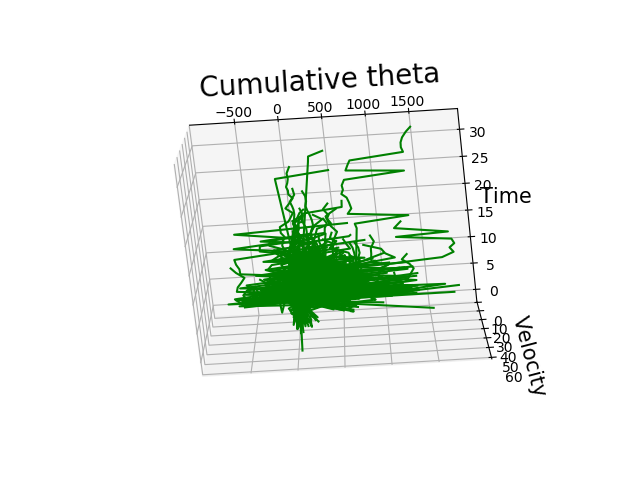

C:\Users\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-cop

In [26]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import csv
%matplotlib notebook

plot_step = 3   # specify here the n:th number of step that will be used in the plot ( this is to remove noice)
                    # if plot_step = 1 all data points will be used

# Loading original tracks data:
data = pd.read_csv(r'C:\Users\Desktop\CAS\Project_course_math_stat_modelling\2017_05_17_L\xy_L_time_matching.csv')
data = data.drop(data.index[0])   # drops the first row
df_xy = data

# Loading file which contains state vector for left turn paths:
state_data = pd.read_csv(r'C:\Users\Desktop\CAS\Project_course_math_stat_modelling\2017_05_17_L\state_vector_L.csv',index_col=False, header=None,sep=',')
df_state = state_data
df_state.columns = df_state.iloc[0]
df_state = df_state.drop(df_state.index[0])   # drops the first row

df_state['Delta theta'] = df_state['Delta theta'].astype(float)
df_state['Velocity'] = df_state['Velocity'].astype(float)
#print(df_test.dtypes)
fig = plt.figure()
ax = fig.gca(projection='3d')

# creating empty data frame to store path where outliers are removed (needed to plot paths in map):
df_map = pd.DataFrame()
df_filtered = pd.DataFrame()

grouped = df_state.groupby(['ID'])  
for ID,group in grouped:
    theta = group['Delta theta']
    theta = theta.to_numpy()
    theta = np.insert(theta,0,0)
    theta = theta*180/np.pi
    theta_sum = np.sum(theta)
    
    if theta_sum >= 70 :  
        theta = np.cumsum(theta)
        theta_last = theta[-1]
        time = np.arange(len(group)+1)*0.3
        time_last = time[-1]
        velocity = group['Velocity'].to_numpy()
        velocity = np.insert(velocity,0,0)
        v_plot = velocity[-1]
        plot_data = pd.DataFrame({'Velocity': velocity, 'Cum_theta': theta, 'Time': time})
        time_plot = plot_data['Time'].iloc[::plot_step].to_numpy()
        velocity_plot = plot_data['Velocity'].iloc[::plot_step].to_numpy()
        theta_plot = plot_data['Cum_theta'].iloc[::plot_step].to_numpy()
        ax.plot3D(theta_plot, time_plot,velocity_plot, 'green')
        df_temp = df_xy.loc[df_xy['ID'] == ID, ['ID', 'Time', 'x', 'y']]
        df_map = df_map.append(df_temp)
        df_temp2 = pd.DataFrame({'cumulative theta': theta[1:len(theta)],'time elapsed': time[1:len(time)]})
        group['theta plot'] = theta_last
        group['time plot'] = time_last
        group['v plot'] = v_plot
        group = group.reset_index(drop=True)
        group = pd.concat([df_temp2,group], axis=1)
        df_filtered = df_filtered.append(group)
              
# label axes
ax.set_xlabel('Cumulative theta', fontsize=20)
ax.set_ylabel('Time', fontsize=15)
ax.set_zlabel('Velocity', fontsize=15)
plt.show()

# path to to put saved file:
path = r'C:\Users\Desktop\CAS\Project_course_math_stat_modelling\2017_05_17_L'

# the file is currently named 'xy_right_time_matching.csv':
df_map.to_csv(os.path.join(path, r'xy_L_filtered_2017_05_17.csv'), index=False)

# the file is currently named 'state_vector_right_turn.csv':
df_filtered.to_csv(os.path.join(path, r's_vect_L_2017_05_17.csv'), index=False)



**(2017-05-17 L lower quadrant) Doing some further filtering and make 3D plot :**

In [102]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import csv
%matplotlib notebook

plot_step = 1   # specify here the n:th number of step that will be used in the plot ( this is to remove noice)
                    # if plot_step = 1 all data points will be used

# Loading file which contains x-y coord for left turn paths:
cols = ['ID','Time','x','y']
xy_data = pd.read_csv(r'C:\Users\Desktop\CAS\Project_course_math_stat_modelling\2017_05_17_L\xy_L_lower_time_matching.csv',index_col=False, header=None,sep=',',names=cols )
df_xy = xy_data
df_xy = df_xy.drop(df_xy.index[0])   # drops the first row

# Loading file which contains state vector for left turn paths:
state_data = pd.read_csv(r'C:\Users\Desktop\CAS\Project_course_math_stat_modelling\2017_05_17_L\state_vector_L_lower.csv',index_col=False, header=None,sep=',')
df_state = state_data
df_state.columns = df_state.iloc[0]
df_state = df_state.drop(df_state.index[0])   # drops the first row

df_state['Delta theta'] = df_state['Delta theta'].astype(float)
df_state['Velocity'] = df_state['Velocity'].astype(float)
#print(df_test.dtypes)
fig = plt.figure()
ax = fig.gca(projection='3d')

# creating empty data frame to store path where outliers are removed (needed to plot paths in map):
df_map = pd.DataFrame()
df_filtered = pd.DataFrame()

grouped = df_state.groupby(['ID'])  
for ID,group in grouped:
    theta = group['Delta theta']
    theta = theta.to_numpy()
    theta = np.insert(theta,0,0)
    theta = theta*180/np.pi
    theta = np.cumsum(theta) 
    theta_sum = theta[-1]
    time = np.arange(len(group)+1)*0.3
    if not((theta < -300).any() or (theta > 100).any()) or (theta > -20).all() or (group.shape[0] < 25):  # filtering out outliers for cumulative theta values 
        time_last = time[-1]
        velocity = group['Velocity'].to_numpy()
        velocity = np.insert(velocity,0,0)
        v_plot = velocity[-1]
        plot_data = pd.DataFrame({'Velocity': velocity, 'Cum_theta': theta, 'Time': time})
        time_plot = plot_data['Time'].iloc[::plot_step].to_numpy()
        velocity_plot = plot_data['Velocity'].iloc[::plot_step].to_numpy()
        theta_plot = plot_data['Cum_theta'].iloc[::plot_step].to_numpy()
        ax.plot3D(theta_plot, time_plot,velocity_plot, 'green')
        df_temp = df_xy.loc[df_xy['ID'] == ID, ['ID', 'Time', 'x', 'y']]
        df_map = df_map.append(df_temp)
        df_temp2 = pd.DataFrame({'cumulative theta': theta[1:len(theta)],'time elapsed': time[1:len(time)]})
        group['theta plot'] = theta_sum
        group['time plot'] = time_last
        group['v plot'] = v_plot
        group = group.reset_index(drop=True)
        group = pd.concat([df_temp2,group], axis=1)
        df_filtered = df_filtered.append(group)
              
# label axes
ax.set_xlabel('Cumulative theta', fontsize=20)
ax.set_ylabel('Time', fontsize=15)
ax.set_zlabel('Velocity', fontsize=15)
plt.show()

# path to to put saved file:
path = r'C:\Users\Desktop\CAS\Project_course_math_stat_modelling\2017_05_17_L'

# the file is currently named 'xy_right_time_matching.csv':
df_map.to_csv(os.path.join(path, r'xy_L_filtered_2017_05_17.csv'), index=False)

# the file is currently named 'state_vector_right_turn.csv':
df_filtered.to_csv(os.path.join(path, r's_vect_L_2017_05_17.csv'), index=False)



          ID                     Time                    x                   y
1  200018361  2017-05-17 05:47:08.203  -11.358349050145092    20.1766929315972
2  200018361  2017-05-17 05:47:08.456  -11.163352783649854   19.83313206017017
3  200018361  2017-05-17 05:47:08.708  -11.118241429081287    19.0100603990802
4  200018361  2017-05-17 05:47:08.960  -11.112277911044538  18.606524415271664
5  200018361  2017-05-17 05:47:09.213   -11.14180365828064  18.389214189230948


<IPython.core.display.Javascript object>

C:\Users\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-cop

KeyboardInterrupt: 

**(file: 2017-05-11) Selecting x-y coordinates which only contain LEFT turn :**

In [46]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import os
import csv

num_TOs = 1500
# coordinate boundaries below are according to 'coordinate_system.pgn' after matrix rotation of xy-data by angle theta:
x_left_bound = -35
x_right_bound = -1
y_upper_bound = -20
y_lower_bound = 22

x_condition_2 = -20
y_condition_2 = 0

y_condition_3 = 2
y_condition_4 = -8
x_condition_3 = 0
theta = 0.588

# Loading original tracks data:
cols = ['ID','Time','x', 'y','Speed','Type','Estimated']
data = pd.read_csv(r'C:\Users\Desktop\CAS\Project_course_math_stat_modelling\2017_05_17_L\2017-05-11_00h_tracks.csv', index_col=False, header=None, sep=';', names=cols)
data = data.drop(data.index[0])   # drops the first row
df1 = data[(data['Type'] == 2)]  # only selecting TO of type 2 (car)



# rotate x-y-coordinates by theta to align the road with the x-y axis in the map:
#df1['x_rot'] = df1['x'].multiply(np.cos(theta)) - df1['y'].multiply(np.sin(theta))
#df1['y_rot'] = df1['x'].multiply(np.sin(theta)) + df1['y'].multiply(np.cos(theta))


# creating new data frame for plotting trajectories: 
df0 = pd.DataFrame(columns=['ID', 'Time', 'x', 'y'])

grouped = df1.groupby(['ID'])   # selecting only TO ID:s that fullfill x-y coord. condition for right turn
for ID,group in grouped:
    
    df_temp = pd.DataFrame({'x_cond':group['x'].between(x_left_bound, x_right_bound),
                            'y_cond':group['y'].between(y_upper_bound, y_lower_bound)
                            ,'x_cond2':(group['x'] < 3).all()
                            ,'y_cond2':(group['y'] > -20).all()
                            # ,'y_cond3':(group['y'] < 17).all()
                           })
    if df_temp.all(axis=None):   # if boundary conditions for x and y are fullfilled
        df0 = df0.append(group[['ID','Time','x','y']])

# doing 2nd filtering:
'''
# creating new data frame for plotting trajectories: 
df = pd.DataFrame(columns=['ID', 'Time', 'x', 'y'])

grouped = df0.groupby(['ID'])   # selecting only TO ID:s that fullfill x-y coord. condition for right turn
for ID,group in grouped:
    
    df_temp = pd.DataFrame({'y_cond3':[(group['y_rot'] < y_condition_3).any()] 
                           ,'y_cond4':[(group['y_rot'] < y_condition_4).any()] 
                           ,'x_cond3':[(group['x_rot'] > x_condition_3).any()] })
                          
    if df_temp.all(axis=None):   # if boundary conditions for x and y are fullfilled
        df = df.append(group[['ID','Time','x','y']])
'''
# path to to put saved file:
path = r'C:\Users\Desktop\CAS\Project_course_math_stat_modelling\2017_05_17_L'

# the file is currently named 'selected_path.csv':
df0.to_csv(os.path.join(path, r'xy_L_11.csv'), index=False)

print('Selected paths saved to csv !')


KeyboardInterrupt: 

**Doing some further filtering after visualizing in map :**

In [368]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import os
import csv
'''
After visualizing file: xy_left_turn.csv on map, one can set some conditions on xy-coord. to remove outliers
'''


# Loading original tracks data:
#cols = ['ID','Time','x', 'y','Speed','Type','Estimated']
data = pd.read_csv(r'C:\Users\Desktop\CAS\Project_course_math_stat_modelling\2017_05_17_L\xy_left_turn.csv')
data = data.drop(data.index[0])   # drops the first row

df1 = data
# rotate x-y-coordinates by theta to align the road with the x-y axis in the map:
#df1['x_rot'] = df1['x'].multiply(np.cos(theta)) - df1['y'].multiply(np.sin(theta))
#df1['y_rot'] = df1['x'].multiply(np.sin(theta)) + df1['y'].multiply(np.cos(theta))
#df_temp = df1[['ID','x','y']].loc[(df1['x_rot'] < -5).any() and (df1['x_rot'] > -12).any() and (df1['y_rot'] < -2).any()]

df_temp = df1.loc[df1['x'] <2]
df_temp = df_temp.loc[df1['x'] > - 5]
df_temp = df_temp.loc[df1['y'] < - 4.5]
#df_temp3 = df1[['ID','x','y']].loc[(df1['x'] < -17)& (df1['x'] > -30) & (df1['y'] < -16.127)]
#df_temp2 = df1[['ID','x','y']].loc[(df1['x'] > -13) & (df1['y'] > 0)]

#del df1['x_rot']
#del df1['y_rot']

print(len(pd.unique(df_temp['ID'])))

print(pd.unique(df_temp['ID']))

print(len(pd.unique(df_temp['ID'])))

print(pd.unique(df_temp['ID']))

print(len(pd.unique(df1['ID'])))

'''
df = df1.loc[df1['ID']!=200029706 ]

df = df.loc[df['ID']!= 200041829 ]

df = df.loc[df['ID']!= 200048743 ]

df = df.loc[df['ID']!=200055744 ]

df = df.loc[df['ID']!=200067566 ]

df = df.loc[df['ID']!=200069815 ]

df = df.loc[df['ID']!=200070553 ]

df = df.loc[df['ID']!=200070974 ]

df = df.loc[df['ID']!=200073761 ]


df = df.loc[df['ID']!=200075824 ]

df = df.loc[df['ID']!=200027095 ]

df = df.loc[df['ID']!=200048743]


df = df.loc[df['ID']!=200025273]

df = df.loc[df['ID']!=200039921]

df = df.loc[df['ID']!=200070339]
df = df.loc[df['ID']!=200077290]
'''

df = df.loc[df['ID']!=200048743]

df = df.loc[df['ID']!=200027449]

df = df.loc[df['ID']!=200070339]

df = df.loc[df['ID']!=200103456]

print(len(pd.unique(df1['ID'])))


# path to to put saved file:
path = r'C:\Users\Desktop\CAS\Project_course_math_stat_modelling\2017_05_17_L'

# the file is currently named 'selected_path.csv':
df.to_csv(os.path.join(path, r'xy_left_turn_filtered.csv'), index=False)

print('Selected paths saved to csv !')

#print(pd.unique(df1['ID'].loc[df1['x']> 14.2]))
#print('\n')

#print(len(pd.unique(df1['ID'].loc[df1['x']> 14.2])))

6
[200027095 200029706 200048743 200055744 200067566 200069815]
6
[200027095 200029706 200048743 200055744 200067566 200069815]
40
40
hej
40
Selected paths saved to csv !


**Selecting LEFT turn paths from the file above that corresponds to the time interval calculated from the GridExtractor, also choosing the data from GridExtractor that matches with the file above , some error to check later , could not extract xy-time matching with conditions  :**

In [369]:
'''
coordinates for restricted area in 'result_L.csv' is : [[[-35,-20],[8,-20]],[[-35,20],[8,20]]]
'''
import pandas as pd
from pandas import DataFrame
import numpy as np
from datetime import datetime
from datetime import timedelta
import os


# num_TOs = 1500

# Loading file which contains x-y coord for right turn paths:
cols = ['ID','Time','x','y']
data1 = pd.read_csv(r'C:\Users\Desktop\CAS\Project_course_math_stat_modelling\2017_05_17_L\xy_left_turn_filtered.csv',index_col=False, header=None,sep=',',names=cols )
data1 = data1.drop(data1.index[0])   # drops the first row

#df1 = data1[(data1['Type'] == 2)]  # only selecting TO of type 2 (car), allready filltered out above
df1 = data1
df1['Time'] = pd.to_datetime(df1['Time']) 
df1['Time'] = df1['Time'].astype('datetime64[ns]')
df1['ID'] = df1['ID'].astype('int32')
df1['ID'] = pd.to_numeric(df1['ID'])

# Loading data with occupancy grid:
data2 = pd.read_csv(r'C:\Users\Desktop\CAS\Project_course_math_stat_modelling\2017_05_17_L\result_2017_05_17_L_large.csv')
data2['ID'] = data2['Object id']
del data2['Object id']
del data2['State time']

# choosing random TO IDs in df2:
#TO_unique = df2.ID.unique()
#rand_ID = np.random.choice(TO_unique, num_TOs, replace=False)
#df2 = df2.loc[df2['ID'].isin(rand_ID)]

# choosing ID:s in df2 that also exists in df1:
df2 = data2.loc[data2['ID'].isin(df1['ID'])]
df2['ID'] = df2['ID'].astype('int32')
#print(df2.dtypes)
# choosing ID:s in df1 that is also existing in df2:
df1 = df1.loc[df1['ID'].isin(df2['ID'])]

# check if they have identical ID:s:
#ID_df1 = df1.ID.unique()
#ID_df2 = df2.ID.unique()
#ID_df1 = np.sort(ID_df1, axis=None)
#ID_df2 = np.sort(ID_df2, axis=None)
#print(np.array_equal(ID_df1, ID_df2))


# calculating state time for data containing occupancy grid:
df2['Time id'] = df2['Time id'].astype(float)
start_time = pd.to_datetime('2017-05-17 00:00:08.485') 
df2['State time'] = start_time + timedelta(seconds=0.3)*df2['Time id'] - timedelta(seconds=0.632)


#df2['Time_id_unique'] = (df2['Time id'].diff() != 1).cumsum()  # rows with consequtive increasing values gets same index


# creating new data frame for plotting trajectories in map: 
df = pd.DataFrame(columns=['ID', 'Time', 'x', 'y'])

# creating empty data frame for state vector:
df_state = pd.DataFrame()

# selecting x-y data that corresponds to the output from GridExtractor (for visualization of tracks in map)
# also selecting the corresponding state vectors stored in df_state for clustering:
grouped = df2.groupby(['ID'])  
for ID,group in grouped:
    df_temp = df1.loc[df1['ID'] == ID, ['ID', 'Time', 'x', 'y']]
    #df_temp = df_temp.loc[(df_temp['Time'] >= group['State time'].iloc[0]) & (df_temp['Time'] <= group['State time'].iloc[-1])]
    #if len(df_temp.index) > 5:    # only using ID:s containing more than 30 data points
    df = df.append(df_temp)
    df_state = df_state.append(group)

# path to to put saved file:
path = r'C:\Users\Desktop\CAS\Project_course_math_stat_modelling\2017_05_17_L'

# the file is currently named 'xy_right_time_matching.csv':
df.to_csv(os.path.join(path, r'xy_left_time_matching.csv'), index=False)

# the file is currently named 'state_vector_left_turn.csv':
df_state.to_csv(os.path.join(path, r'state_vector_left_turn.csv'), index=False)

print('Selected paths saved to csv !')


C:\Users\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-cop

Selected paths saved to csv !


**Doing some more removal of outliers and creating 3D plot with state vectors and xy-file for trajectory plotting (left turn):**

<IPython.core.display.Javascript object>


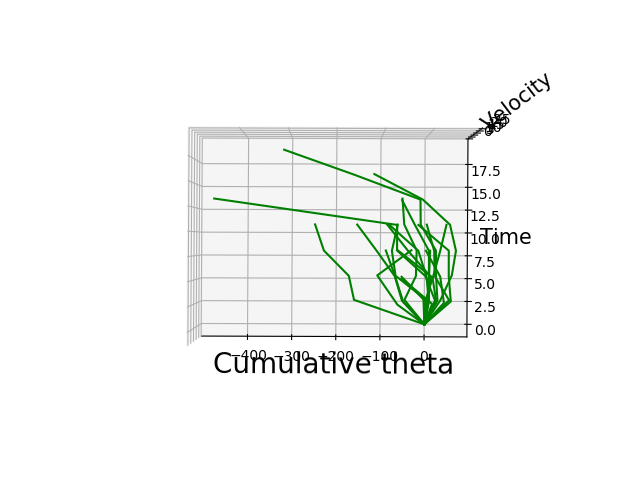

In [381]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import csv
%matplotlib notebook

plot_step = 9   # specify here the n:th number of step that will be used in the plot ( this is to remove noice)
                    # if plot_step = 1 all data points will be used

# Loading file which contains x-y coord for right turn paths:
cols = ['ID','Time','x','y']
xy_data = pd.read_csv(r'C:\Users\Desktop\CAS\Project_course_math_stat_modelling\2017_05_17_L\xy_left_time_matching.csv',index_col=False, header=None,sep=',',names=cols )
df_xy = xy_data
df_xy = df_xy.drop(df_xy.index[0])   # drops the first row

# Loading file which contains state vector for right turn paths:
state_data = pd.read_csv(r'C:\Users\Desktop\CAS\Project_course_math_stat_modelling\2017_05_17_L\state_vector_left_turn.csv',index_col=False, header=None,sep=',')
df_state = state_data
df_state.columns = df_state.iloc[0]
df_state = df_state.drop(df_state.index[0])   # drops the first row
df_state['Delta theta'] = df_state['Delta theta'].astype(float)
df_state['Velocity'] = df_state['Velocity'].astype(float)
#print(df_test.dtypes)
fig = plt.figure()
ax = fig.gca(projection='3d')

# creating empty data frame to store path where outliers are removed (needed to plot paths in map):
df_map = pd.DataFrame()
df_filtered = pd.DataFrame()
grouped = df_state.groupby(['ID'])  
for ID,group in grouped:
    theta = group['Delta theta']
    theta = theta.to_numpy()
    theta = np.insert(theta,0,0)
    theta = theta*180/np.pi
    theta = np.cumsum(theta)
    time = np.arange(len(group)+1)*0.3
    if not((theta > 150).any() or (time > 23).any() ):  # filtering out outliers for cumulative theta values 
        velocity = group['Velocity'].to_numpy()
        velocity = np.insert(velocity,0,0)
        
        plot_data = pd.DataFrame({'Velocity': velocity, 'Cum_theta': theta, 'Time': time})
        time_plot = plot_data['Time'].iloc[::plot_step].to_numpy()
        velocity_plot = plot_data['Velocity'].iloc[::plot_step].to_numpy()
        theta_plot = plot_data['Cum_theta'].iloc[::plot_step].to_numpy()
        ax.plot3D(theta_plot, time_plot,velocity_plot, 'green')
        df_temp = df_xy.loc[df_xy['ID'] == ID, ['ID', 'Time', 'x', 'y']]
        df_map = df_map.append(df_temp)
        df_temp2 = pd.DataFrame({'cumulative theta': theta[1:len(theta)],'time elapsed': time[1:len(time)]})
        group = group.reset_index(drop=True)
        group = pd.concat([df_temp2,group], axis=1)
        df_filtered = df_filtered.append(group)
              
# label axes
ax.set_xlabel('Cumulative theta', fontsize=20)
ax.set_ylabel('Time', fontsize=15)
ax.set_zlabel('Velocity', fontsize=15)
plt.show()

# path to to put saved file:
path = r'C:\Users\Desktop\CAS\Project_course_math_stat_modelling\2017_05_17_L'

# the file is currently named 'xy_right_time_matching.csv':
df_map.to_csv(os.path.join(path, r'xy_left_filtered_cut.csv'), index=False)

# the file is currently named 'state_vector_right_turn.csv':
df_filtered.to_csv(os.path.join(path, r'state_vector_L_filtered_cut.csv'), index=False)

